# **Practice Lab: Actor-Critic with Softmax Policy - Pendulum Swing-Up**

**In this assignment, you will:**

1.   Develop a softmax-based Actor-Critic (AC) agent for a **continuing** task, utilizing the **average reward** framework.
2.   Learn how to represent the policy as a parameterized function for discrete action spaces.
3.   Explore methods to approximate and sample the gradient of the objective for updating the actor.
4.   Understand the process of updating the critic using the differential temporal difference (TD) error.




## Pendulum Swing-Up Environment

This project is designed to implement the **Pendulum-v0** environment in OpenAI Gym using **policy-gradient** and **average reward framework**. The code is broken down into various sections to make it easier to understand how Softmax Actor-Critic with average reward works.

<img src="https://mspries.github.io/img/jimmy-pendulum/pendulum.gif" alt="Drawing" style="width: 400px;"/>

The environment features a single pendulum capable of full 360-degree rotation. The pendulum is controlled by applying torque at its pivot point. The objective is to swing the pendulum from its resting position (hanging downward with zero velocity) to an upright, balanced position and maintain it there as long as possible. The pendulum moves freely, influenced only by gravity and the torque applied by the agent.

The state is 2-dimensional, which consists of the current angle $\beta \in [-\pi, \pi]$ (angle from the vertical upright position) and current angular velocity $\dot{\beta} \in (-8.0, 8.0)$. The angular velocity is constrained in order to avoid damaging the pendulum system.
The action is the angular acceleration, with discrete values $a \in [-2, 2]$ applied to the pendulum.
For more details on environment dynamics you can refer to the original paper.

The objective is to swing up the pendulum and maintain it in the upright position.

Similar to the Mountain Car environment, the pendulum's torque is insufficient to directly move it to the desired position. The agent must learn to first swing the pendulum away from the target to build momentum, enabling a successful swing-up. Once upright, the agent must stabilize the pendulum and prevent it from falling, mastering the balance in this inherently unstable position.

### Objective
**Actor-Critic Framework**:
   - **Actor**: Parameterizes the policy $\pi(a|s;\theta)$ as a softmax function.
   - **Critic**: Approximates the value function using the **differential temporal difference (TD) error**.

## Packages


In [1]:
!wget https://raw.githubusercontent.com/kamenbliznashki/sutton_barto/refs/heads/master/tiles3.py


--2025-01-22 09:41:12--  https://raw.githubusercontent.com/kamenbliznashki/sutton_barto/refs/heads/master/tiles3.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3932 (3.8K) [text/plain]
Saving to: ‘tiles3.py’

tiles3.py           100%[===================>]   3.84K  --.-KB/s    in 0s      

2025-01-22 09:41:12 (57.0 MB/s) - ‘tiles3.py’ saved [3932/3932]



In [2]:
# fix typo in original file...
with open("tiles3.py", "r+") as file:
       content = file.read()
       new_content = content.replace("wrawidths", "wrapwidths")
       file.seek(0)
       file.write(new_content)
       file.truncate()

In [3]:
# Import necessary libraries
!pip install gym --upgrade

import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
import imageio
import pickle

import tiles3 as tc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 9.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827696 sha256=c70749c139adf80cb9bb75c64655e8afca9884faa56c5c45c2e906c9b47da9fe
  Stored in directory: /root/.cache/pip/wheels/1c/77/9e/9af5470201a0b0543937933ee99ba884cd237d2faefe8f4d37
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.0 requires gym<=0.25.2, but you have gym 0.26.2 which is incompatible.


## 1. Create Tile Coding Helper Function

Tile coding is introduced in [Section 9.5.4 of the textbook](http://www.incompleteideas.net/book/RLbook2018.pdf#page=239) of the textbook as a way to create features that can both provide good generalization and discrimination. It consists of multiple overlapping tilings, where each tiling is a partitioning of the space into tiles.


<img align="Left" src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*AZXJ9lWBReLEcEQDt0_jpQ.jpeg" width = 80% >


In [4]:
!wget https://raw.githubusercontent.com/kamenbliznashki/sutton_barto/refs/heads/master/tiles3.py

# Fix typo in the original file
with open("tiles3.py", "r+") as file:
    content = file.read()
    new_content = content.replace("wrawidths", "wrapwidths")
    file.seek(0)
    file.write(new_content)
    file.truncate()

# Import necessary libraries
!pip install gym --upgrade

import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
import imageio
import pickle

import tiles3 as tc

class PendulumTileCoder:
    def __init__(self, iht_size=4096, num_tilings=32, num_tiles=8):
        """
        Initializes the Pendulum Tile Coder
        Initializers:
        iht_size -- int, the size of the index hash table, typically a power of 2
        num_tilings -- int, the number of tilings
        num_tiles -- int, the number of tiles. Here both the width and height of the tiles are the same

        Class Variables:
        self.iht -- tc.IHT, the index hash table that the tile coder will use
        self.num_tilings -- int, the number of tilings the tile coder will use
        self.num_tiles -- int, the number of tiles the tile coder will use
        """

        self.num_tilings = num_tilings
        self.num_tiles = num_tiles
        self.iht = tc.IHT(iht_size)

    def get_tiles(self, angle, ang_vel):
        """
        Takes in an angle and angular velocity from the pendulum environment
        and returns a numpy array of active tiles.

        Arguments:
        angle -- float, the angle of the pendulum between -np.pi and np.pi
        ang_vel -- float, the angular velocity of the agent between -8.0 and 8.0

        returns:
        tiles -- np.array, active tiles

        """

        ### Set the max and min of angle and ang_vel to scale the input
        ANGLE_MIN = -np.pi
        ANGLE_MAX = np.pi
        ANG_VEL_MIN = -8.0
        ANG_VEL_MAX = 8.0

        ### Use the ranges above and self.num_tiles to set angle_scale and ang_vel_scale
        angle_scale = self.num_tiles / (ANGLE_MAX - ANGLE_MIN)
        ang_vel_scale = self.num_tiles / (ANG_VEL_MAX - ANG_VEL_MIN)

        # Get tiles by calling tc.tileswrap method
        # wrapwidths specify which dimension to wrap over and its wrapwidth
        tiles = tc.tileswrap(self.iht, self.num_tilings, [angle * angle_scale, ang_vel * ang_vel_scale], wrapwidths=[self.num_tiles, False])

        return np.array(tiles)

# Example usage of the PendulumTileCoder
if __name__ == "__main__":
    tile_coder = PendulumTileCoder()

    # Test with some example values
    angle = np.pi / 4  # 45 degrees
    ang_vel = 4.0  # Example angular velocity

    active_tiles = tile_coder.get_tiles(angle, ang_vel)
    print("Active tiles:", active_tiles)


--2025-01-22 09:42:56--  https://raw.githubusercontent.com/kamenbliznashki/sutton_barto/refs/heads/master/tiles3.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3932 (3.8K) [text/plain]
Saving to: ‘tiles3.py.1’

tiles3.py.1         100%[===================>]   3.84K  --.-KB/s    in 0s      

2025-01-22 09:42:56 (56.8 MB/s) - ‘tiles3.py.1’ saved [3932/3932]

Active tiles: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


Run the following code to verify `PendulumTilecoder`

In [5]:
## Test Code for PendulumTileCoder ##
# Your tile coder should also work for other num. tilings and num. tiles
test_obs = [[-np.pi, 0], [-np.pi, 0.5], [np.pi, 0], [np.pi, -0.5], [0, 1]]

pdtc = PendulumTileCoder(iht_size=4096, num_tilings=8, num_tiles=4)

result=[]
for obs in test_obs:
    angle, ang_vel = obs
    tiles = pdtc.get_tiles(angle=angle, ang_vel=ang_vel)
    result.append(tiles)

for tiles in result:
    print(tiles)

print()
print("Expected results:")
expected = """[0 1 2 3 4 5 6 7]
[0 1 2 3 4 8 6 7]
[0 1 2 3 4 5 6 7]
[9 1 2 3 4 5 6 7]
[10 11 12 13 14 15 16 17]
"""
print(expected)


[0 1 2 3 4 5 6 7]
[0 1 2 3 4 8 6 7]
[0 1 2 3 4 5 6 7]
[9 1 2 3 4 5 6 7]
[10 11 12 13 14 15 16 17]

Expected results:
[0 1 2 3 4 5 6 7]
[0 1 2 3 4 8 6 7]
[0 1 2 3 4 5 6 7]
[9 1 2 3 4 5 6 7]
[10 11 12 13 14 15 16 17]



## 2. Discretizing the Pendulum Environment

In [6]:
# Define a wrapper to discretize the action space
# We discritize the action-space into num_bins actions
class DiscretizedPendulumEnv():
    def __init__(self, env, num_bins=9):
        self.env = env
        self.num_bins = num_bins
        self.action_space = np.linspace(env.action_space.low[0], env.action_space.high[0], num_bins)
        self.observation_space = env.observation_space

    def reset(self, seed=0):
        return self.env.reset(seed = seed)

    def step(self, action_idx):
        action = [self.action_space[action_idx]]
        obs, reward, done, info, _ = self.env.step(action)
        return obs, reward, done, info, _

    def render(self):
        return self.env.render()

    def close(self):
        self.env.close()

## 3. Create Softmax Actor-Critic with Average Reward Agent

Now that we implemented PendulumTileCoder let's create the agent that interacts with the environment. We will implement the same average reward Actor-Critic algorithm presented in the videos.

This agent consists of two main components: the Actor and the Critic. The Actor is responsible for learning a parameterized policy, while the Critic estimates the state-value function. In this setup, the environment features discrete actions, and the Actor employs a softmax policy based on exponentiated action preferences. The Actor's learning process involves using a sample-based estimate of the gradient for the average reward objective. Meanwhile, the Critic updates its value estimates using the average reward variant of the semi-gradient TD(0) algorithm.

In this section, you will be implementing `agent_policy`, `agent_start`, `agent_step`, and `agent_end`.

### 3.1 Compute Softmax Probability

In this section, you will implement the `compute_softmax_prob` function.

This function calculates the softmax probabilities for all possible actions, given the actor weights `actor_w` and the active tiles `tiles`. These probabilities will later be used in the `agent_policy` function to sample actions.

**Softmax Policy Representation**

The softmax policy is mathematically represented as:
$\pi(a|s, \mathbf{\theta}) \doteq \frac{e^{h(s,a,\mathbf{\theta})}}{\sum_{b}e^{h(s,b,\mathbf{\theta})}}$
where:
- $h(s, a, \mathbf{\theta})$: The **state-action preference**, defined as:
$h(s, a, \mathbf{\theta}) \doteq \mathbf{\theta}^\top \mathbf{x}_h(s, a)$

**Computing State-Action Preferences**

Using the active tiles `tiles` for state $s$, the state-action preference $h(s,a,\mathbf{\theta})$ can be computed as:
$h(s,a,\mathbf{\theta}) = \texttt{actor_w[a][tiles].sum()}$

**Avoiding Numerical Overflow: Exp-Normalize Trick**

To avoid numerical overflow when exponentiating large numbers, we use the **exp-normalize trick**. This leverages the shift-invariance property of the softmax policy:
$\pi(a|s, \mathbf{\theta}) = \frac{e^{h(s,a,\mathbf{\theta})}}{\sum_{b}e^{h(s,b,\mathbf{\theta})}} = \frac{e^{h(s,a,\mathbf{\theta}) - c}}{\sum_{b}e^{h(s,b,\mathbf{\theta}) - c}}$
Here, $c \in \mathbb{R}$ is a constant subtracted from all state-action preferences. Commonly, we set:
$c = \max_b h(s, b, \mathbf{\theta})$
This subtraction ensures numerical stability while keeping the policy unchanged.

In [8]:
import numpy as np
import tiles3 as tc

class PendulumTileCoder:
    def __init__(self, iht_size=4096, num_tilings=32, num_tiles=8):
        """
        Initializes the Pendulum Tile Coder
        Initializers:
        iht_size -- int, the size of the index hash table, typically a power of 2
        num_tilings -- int, the number of tilings
        num_tiles -- int, the number of tiles. Here both the width and height of the tiles are the same

        Class Variables:
        self.iht -- tc.IHT, the index hash table that the tile coder will use
        self.num_tilings -- int, the number of tilings the tile coder will use
        self.num_tiles -- int, the number of tiles the tile coder will use
        """

        self.num_tilings = num_tilings
        self.num_tiles = num_tiles
        self.iht = tc.IHT(iht_size)

    def get_tiles(self, angle, ang_vel):
        """
        Takes in an angle and angular velocity from the pendulum environment
        and returns a numpy array of active tiles.

        Arguments:
        angle -- float, the angle of the pendulum between -np.pi and np.pi
        ang_vel -- float, the angular velocity of the agent between -8.0 and 8.0

        returns:
        tiles -- np.array, active tiles

        """

        ### Set the max and min of angle and ang_vel to scale the input
        ANGLE_MIN = -np.pi
        ANGLE_MAX = np.pi
        ANG_VEL_MIN = -8.0
        ANG_VEL_MAX = 8.0

        ### Use the ranges above and self.num_tiles to set angle_scale and ang_vel_scale
        angle_scale = self.num_tiles / (ANGLE_MAX - ANGLE_MIN)
        ang_vel_scale = self.num_tiles / (ANG_VEL_MAX - ANG_VEL_MIN)

        # Get tiles by calling tc.tileswrap method
        # wrapwidths specify which dimension to wrap over and its wrapwidth
        tiles = tc.tileswrap(self.iht, self.num_tilings, [angle * angle_scale, ang_vel * ang_vel_scale], wrapwidths=[self.num_tiles, False])

        return np.array(tiles)

# Define a wrapper to discretize the action space
# We discretize the action-space into num_bins actions
class DiscretizedPendulumEnv():
    def __init__(self, env, num_bins=9):
        self.env = env
        self.num_bins = num_bins
        self.action_space = np.linspace(env.action_space.low[0], env.action_space.high[0], num_bins)
        self.observation_space = env.observation_space

    def reset(self, seed=0):
        return self.env.reset(seed=seed)

    def step(self, action_idx):
        action = [self.action_space[action_idx]]
        obs, reward, done, info, _ = self.env.step(action)
        return obs, reward, done, info, _

    def render(self):
        return self.env.render()

    def close(self):
        self.env.close()

def compute_softmax_prob(actor_w, tiles):
    """
    Computes softmax probability for all actions

    Args:
    actor_w - np.array, an array of actor weights
    tiles - np.array, an array of active tiles

    Returns:
    softmax_prob - np.array, an array of size equal to num. actions, and sums to 1.
    """

    # First compute the list of state-action preferences
    state_action_preferences = []
    ### START CODE HERE ###
    state_action_preferences = np.sum(actor_w[:, tiles], axis=1)
    ### END CODE HERE ###

    # Set the constant c by finding the maximum of state-action preferences
    ### START CODE HERE ###
    c = np.max(state_action_preferences)
    ### END CODE HERE ###

    # Compute the numerator by subtracting c from state-action preferences and exponentiating it (use np.exp)
    ### START CODE HERE ###
    numerator = np.exp(state_action_preferences - c)
    ### END CODE HERE ###

    # Next compute the denominator by summing the values in the numerator (use np.sum)
    ### START CODE HERE ###
    denominator = np.sum(numerator)
    ### END CODE HERE ###

    # Create a probability array by dividing each element in numerator array by denominator
    ### START CODE HERE ###
    softmax_prob = numerator / denominator
    ### END CODE HERE ###

    return softmax_prob


Test to verify `compute_softmax_prob`.

In [9]:
## Test Code for compute_softmax_prob()

# set tile-coder
iht_size = 4096
num_tilings = 8
num_tiles = 8
test_tc = PendulumTileCoder(iht_size=iht_size, num_tilings=num_tilings, num_tiles=num_tiles)

num_actions = 3
actions = list(range(num_actions))
actor_w = np.zeros((len(actions), iht_size))

# setting actor weights such that state-action preferences are always [-1, 1, 2]
actor_w[0] = -1./num_tilings
actor_w[1] = 1./num_tilings
actor_w[2] = 2./num_tilings

# obtain active_tiles from state
state = [-np.pi, 0.]
angle, ang_vel = state
active_tiles = test_tc.get_tiles(angle, ang_vel)

# compute softmax probability
softmax_prob = compute_softmax_prob(actor_w, active_tiles)
print('softmax probability: {}'.format(softmax_prob))

print()
expected = """ [0.0351, 0.2595, 0.7054]"""
print("Expected results:", expected)

softmax probability: [0.03511903 0.25949646 0.70538451]

Expected results:  [0.0351, 0.2595, 0.7054]


### 3.2 Implement Agent Methods

- `agent_init()`: Initializes all required agent variables.
- **Tasks**: Implement `agent_start()` and `agent_step()`. No need for `agent_end()` since this is a continuing task.
- **Key Functions**:
  - `compute_softmax_prob()`: Computes action probabilities, used in `agent_policy()`.
  - `agent_policy()`: Determines the action policy, used in both `agent_start()` and `agent_step()`.
- **Actor-Critic Updates**: Follow the Actor-Critic algorithm to update both the Actor and Critic components during implementation.

We approximate $q_\pi$ in the Actor update using one-step bootstrapped return($R_{t+1} - \bar{R} + \hat{v}(S_{t+1}, \mathbf{w})$) subtracted by current state-value($\hat{v}(S_{t}, \mathbf{w})$), equivalent to TD error $\delta$.

$\delta_t = R_{t+1} - \bar{R} + \hat{v}(S_{t+1}, \mathbf{w}) - \hat{v}(S_{t}, \mathbf{w}) \hspace{6em} (1)$

**Average Reward update rule**: $\bar{R} \leftarrow \bar{R} + \alpha^{\bar{R}}\delta \hspace{4.3em} (2)$

**Critic weight update rule**: $\mathbf{w} \leftarrow \mathbf{w} + \alpha^{\mathbf{w}}\delta\nabla \hat{v}(s,\mathbf{w}) \hspace{2.5em} (3)$

**Actor weight update rule**: $\mathbf{\theta} \leftarrow \mathbf{\theta} + \alpha^{\mathbf{\theta}}\delta\nabla ln \pi(A|S,\mathbf{\theta}) \hspace{1.4em} (4)$


Since we are using linear function approximation and parameterizing a softmax policy, the above update rule can be further simplified using:

$\nabla \hat{v}(s,\mathbf{w}) = \mathbf{x}(s) \hspace{14.2em} (5)$

$\nabla ln \pi(A|S,\mathbf{\theta}) = \mathbf{x}_h(s,a) - \sum_b \pi(b|s, \mathbf{\theta})\mathbf{x}_h(s,b) \hspace{3.3em} (6)$


In [10]:
import numpy as np
import tiles3 as tc

class PendulumTileCoder:
    def __init__(self, iht_size=4096, num_tilings=32, num_tiles=8):
        """
        Initializes the Pendulum Tile Coder
        Initializers:
        iht_size -- int, the size of the index hash table, typically a power of 2
        num_tilings -- int, the number of tilings
        num_tiles -- int, the number of tiles. Here both the width and height of the tiles are the same

        Class Variables:
        self.iht -- tc.IHT, the index hash table that the tile coder will use
        self.num_tilings -- int, the number of tilings the tile coder will use
        self.num_tiles -- int, the number of tiles the tile coder will use
        """

        self.num_tilings = num_tilings
        self.num_tiles = num_tiles
        self.iht = tc.IHT(iht_size)

    def get_tiles(self, angle, ang_vel):
        """
        Takes in an angle and angular velocity from the pendulum environment
        and returns a numpy array of active tiles.

        Arguments:
        angle -- float, the angle of the pendulum between -np.pi and np.pi
        ang_vel -- float, the angular velocity of the agent between -8.0 and 8.0

        returns:
        tiles -- np.array, active tiles

        """

        ### Set the max and min of angle and ang_vel to scale the input
        ANGLE_MIN = -np.pi
        ANGLE_MAX = np.pi
        ANG_VEL_MIN = -8.0
        ANG_VEL_MAX = 8.0

        ### Use the ranges above and self.num_tiles to set angle_scale and ang_vel_scale
        angle_scale = self.num_tiles / (ANGLE_MAX - ANGLE_MIN)
        ang_vel_scale = self.num_tiles / (ANG_VEL_MAX - ANG_VEL_MIN)

        # Get tiles by calling tc.tileswrap method
        # wrapwidths specify which dimension to wrap over and its wrapwidth
        tiles = tc.tileswrap(self.iht, self.num_tilings, [angle * angle_scale, ang_vel * ang_vel_scale], wrapwidths=[self.num_tiles, False])

        return np.array(tiles)

# Define a wrapper to discretize the action space
# We discretize the action-space into num_bins actions
class DiscretizedPendulumEnv():
    def __init__(self, env, num_bins=9):
        self.env = env
        self.num_bins = num_bins
        self.action_space = np.linspace(env.action_space.low[0], env.action_space.high[0], num_bins)
        self.observation_space = env.observation_space

    def reset(self, seed=0):
        return self.env.reset(seed=seed)

    def step(self, action_idx):
        action = [self.action_space[action_idx]]
        obs, reward, done, info, _ = self.env.step(action)
        return obs, reward, done, info, _

    def render(self):
        return self.env.render()

    def close(self):
        self.env.close()

def compute_softmax_prob(actor_w, tiles):
    """
    Computes softmax probability for all actions

    Args:
    actor_w - np.array, an array of actor weights
    tiles - np.array, an array of active tiles

    Returns:
    softmax_prob - np.array, an array of size equal to num. actions, and sums to 1.
    """

    # First compute the list of state-action preferences
    state_action_preferences = []
    ### START CODE HERE ###
    state_action_preferences = np.sum(actor_w[:, tiles], axis=1)
    ### END CODE HERE ###

    # Set the constant c by finding the maximum of state-action preferences
    ### START CODE HERE ###
    c = np.max(state_action_preferences)
    ### END CODE HERE ###

    # Compute the numerator by subtracting c from state-action preferences and exponentiating it (use np.exp)
    ### START CODE HERE ###
    numerator = np.exp(state_action_preferences - c)
    ### END CODE HERE ###

    # Next compute the denominator by summing the values in the numerator (use np.sum)
    ### START CODE HERE ###
    denominator = np.sum(numerator)
    ### END CODE HERE ###

    # Create a probability array by dividing each element in numerator array by denominator
    ### START CODE HERE ###
    softmax_prob = numerator / denominator
    ### END CODE HERE ###

    return softmax_prob

class ActorCriticSoftmaxAgent():
    def __init__(self):
        self.rand_generator = None

        self.actor_step_size = None
        self.critic_step_size = None
        self.avg_reward_step_size = None

        self.tc = None

        self.avg_reward = None
        self.critic_w = None
        self.actor_w = None

        self.actions = None

        self.softmax_prob = None
        self.prev_tiles = None
        self.last_action = None

    def agent_init(self, agent_info={}):
        """Setup for the agent called when the experiment first starts.

        Set parameters needed to setup the semi-gradient TD(0) state aggregation agent.

        Assume agent_info dict contains:
        {
            "iht_size": int
            "num_tilings": int,
            "num_tiles": int,
            "actor_step_size": float,
            "critic_step_size": float,
            "avg_reward_step_size": float,
            "num_actions": int,
            "seed": int
        }
        """

        # set random seed for each run
        self.rand_generator = np.random.RandomState(agent_info.get("seed"))

        iht_size = agent_info.get("iht_size")
        num_tilings = agent_info.get("num_tilings")
        num_tiles = agent_info.get("num_tiles")

        # initialize self.tc to the tile coder we created
        self.tc = PendulumTileCoder(iht_size=iht_size, num_tilings=num_tilings, num_tiles=num_tiles)

        # set step-size accordingly (we normally divide actor and critic step-size by num. tilings
        self.actor_step_size = agent_info.get("actor_step_size")/num_tilings
        self.critic_step_size = agent_info.get("critic_step_size")/num_tilings
        self.avg_reward_step_size = agent_info.get("avg_reward_step_size")

        self.actions = list(range(agent_info.get("num_actions")))

        # Set initial values of average reward, actor weights, and critic weights
        # We initialize actor weights to three times the iht_size.
        # Recall this is because we need to have one set of weights for each of the three actions.
        self.avg_reward = 0.0
        self.actor_w = np.zeros((len(self.actions), iht_size))
        self.critic_w = np.zeros(iht_size)

        self.softmax_prob = None
        self.prev_tiles = None
        self.last_action = None

    def agent_policy(self, active_tiles):
        """ policy of the agent
        Args:
            active_tiles (Numpy array): active tiles returned by tile coder

        Returns:
            The action selected according to the policy
        """

        # compute softmax probability
        softmax_prob = compute_softmax_prob(self.actor_w, active_tiles)

        # Sample action from the softmax probability array
        # self.rand_generator.choice() selects an element from the array with the specified probability
        chosen_action = self.rand_generator.choice(self.actions, p=softmax_prob)

        # save softmax_prob as it will be useful later when updating the Actor
        self.softmax_prob = softmax_prob

        return chosen_action

    def agent_start(self, state):
        """The first method called when the experiment starts, called after
        the environment starts.
        Args:
            state (Numpy array): the state from the environment's env_start function.
        Returns:
            The first action the agent takes.
        """

        angle, ang_vel = state

        ### Use self.tc to get active_tiles using angle and ang_vel
        # set current_action by calling self.agent_policy with active_tiles
        ### START CODE HERE ###
        active_tiles = self.tc.get_tiles(angle, ang_vel)
        current_action = self.agent_policy(active_tiles)
        ### END CODE HERE ###

        self.last_action = current_action
        self.prev_tiles = np.copy(active_tiles)

        return self.last_action


    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (Numpy array): the state from the environment's step based on
                                where the agent ended up after the
                                last step.
        Returns:
            The action the agent is taking.
        """

        angle, ang_vel = state

        ### Use self.tc to get active_tiles using angle and ang_vel
        ### START CODE HERE ###
        active_tiles = self.tc.get_tiles(angle, ang_vel)
        ### END CODE HERE ###

        ### Compute delta
        ### START CODE HERE ###
        delta = reward - self.avg_reward + np.sum(self.critic_w[active_tiles]) - np.sum(self.critic_w[self.prev_tiles])
        ### END CODE HERE ###

        ### update average reward
        ### START CODE HERE ###
        self.avg_reward += self.avg_reward_step_size * delta
        ### END CODE HERE ###

        # update critic weights
        ### START CODE HERE ###
        self.critic_w[self.prev_tiles] += self.critic_step_size * delta
        ### END CODE HERE ###

        # update actor weights
        # We use self.softmax_prob saved from the previous timestep
        for a in self.actions:
            if a == self.last_action:
                self.actor_w[a][self.prev_tiles] += self.actor_step_size * delta * (1 - self.softmax_prob[a])
            else:
                self.actor_w[a][self.prev_tiles] += self.actor_step_size * delta * (0 - self.softmax_prob[a])

        ### set current_action by calling self.agent_policy with active_tiles
        ### START CODE HERE ###
        current_action = self.agent_policy(active_tiles)
        ### END CODE HERE ###

        self.prev_tiles = active_tiles
        self.last_action = current_action

        return self.last_action


    def agent_message(self, message):
        if message == 'get avg reward':
            return self.avg_reward


Test to verify `agent_start()`.
Although there is randomness due to `self.rand_generator.choice()` in `agent_policy()`, we control the seed so your output should match the expected output.

In [11]:
## Test Code for agent_start()##

agent_info = {"iht_size": 4096,
              "num_tilings": 8,
              "num_tiles": 8,
              "actor_step_size": 1e-1,
              "critic_step_size": 1e-0,
              "avg_reward_step_size": 1e-2,
              "num_actions": 3,
              "seed": 99}

test_agent = ActorCriticSoftmaxAgent()
test_agent.agent_init(agent_info)

state = [-np.pi, 0.]

test_agent.agent_start(state)

print("agent active_tiles: {}".format(test_agent.prev_tiles))
print("agent selected action: {}".format(test_agent.last_action))

print()
print("Expected Output:")
print("agent active_tiles: [0 1 2 3 4 5 6 7]")
print("agent selected action: 2")

agent active_tiles: [0 1 2 3 4 5 6 7]
agent selected action: 2

Expected Output:
agent active_tiles: [0 1 2 3 4 5 6 7]
agent selected action: 2


Test to verify `agent_step()`

In [12]:
## Test Code for agent_step()
# Make sure agent_start() and agent_policy() are working correctly first.

env_info = {"seed": 99}
agent_info = {"iht_size": 4096,
              "num_tilings": 8,
              "num_tiles": 8,
              "actor_step_size": 1e-1,
              "critic_step_size": 1e-0,
              "avg_reward_step_size": 1e-2,
              "num_actions": 11,
              "seed": 99}

test_agent = ActorCriticSoftmaxAgent()
test_agent.agent_init(agent_info)

test_env = DiscretizedPendulumEnv(gym.make('Pendulum-v1',  render_mode='rgb_array'), num_bins=agent_info["num_actions"])

# Start env/agent
total_reward = 0.0
num_steps = 1

env_state, _ = test_env.reset(seed=env_info["seed"])
cos_beta, sin_beta, beta_dot = env_state
beta = np.arctan2(sin_beta, cos_beta)
last_state = [beta, beta_dot]

last_action = test_agent.agent_start(last_state)

observation = (last_state, last_action)

# Step env/agent
env_state, reward, done, _, _ = test_env.step(last_action)
cos_beta, sin_beta, beta_dot = env_state
beta = np.arctan2(sin_beta, cos_beta)
last_state = [beta, beta_dot]

total_reward += reward;

num_steps += 1
last_action = test_agent.agent_step(reward, last_state)
roat = (reward, last_state, last_action, done)

print("agent next_action: {}".format(last_action))
print("agent avg reward: {}\n".format(test_agent.avg_reward))
print("agent first 10 values of actor weights[0]: \n{}\n".format(test_agent.actor_w[0][:10]))
print("agent first 10 values of actor weights[1]: \n{}\n".format(test_agent.actor_w[1][:10]))
print("agent first 10 values of actor weights[2]: \n{}\n".format(test_agent.actor_w[2][:10]))
print("agent first 10 values of critic weights: \n{}".format(test_agent.critic_w[:10]))


agent next_action: 5
agent avg reward: -3.770560183025249e-05

agent first 10 values of actor weights[0]: 
[4.28472748e-06 4.28472748e-06 4.28472748e-06 4.28472748e-06
 4.28472748e-06 4.28472748e-06 4.28472748e-06 4.28472748e-06
 0.00000000e+00 0.00000000e+00]

agent first 10 values of actor weights[1]: 
[4.28472748e-06 4.28472748e-06 4.28472748e-06 4.28472748e-06
 4.28472748e-06 4.28472748e-06 4.28472748e-06 4.28472748e-06
 0.00000000e+00 0.00000000e+00]

agent first 10 values of actor weights[2]: 
[4.28472748e-06 4.28472748e-06 4.28472748e-06 4.28472748e-06
 4.28472748e-06 4.28472748e-06 4.28472748e-06 4.28472748e-06
 0.00000000e+00 0.00000000e+00]

agent first 10 values of critic weights: 
[-0.00047132 -0.00047132 -0.00047132 -0.00047132 -0.00047132 -0.00047132
 -0.00047132 -0.00047132  0.          0.        ]


/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


**Expected output**:
    
    agent next_action: 5
    agent avg reward: -3.770560183025249e-05

    agent first 10 values of actor weights[0]:
    [4.28472748e-06 4.28472748e-06 4.28472748e-06 4.28472748e-06
    4.28472748e-06 4.28472748e-06 4.28472748e-06 4.28472748e-06
    0.00000000e+00 0.00000000e+00]

    agent first 10 values of actor weights[1]:
    [4.28472748e-06 4.28472748e-06 4.28472748e-06 4.28472748e-06
    4.28472748e-06 4.28472748e-06 4.28472748e-06 4.28472748e-06
    0.00000000e+00 0.00000000e+00]

    agent first 10 values of actor weights[2]:
    [4.28472748e-06 4.28472748e-06 4.28472748e-06 4.28472748e-06
    4.28472748e-06 4.28472748e-06 4.28472748e-06 4.28472748e-06
    0.00000000e+00 0.00000000e+00]

    agent first 10 values of critic weights:
    [-0.00047132 -0.00047132 -0.00047132 -0.00047132 -0.00047132 -0.00047132
    -0.00047132 -0.00047132  0.          0.        ]

## 4. Run Experiment

Now that we've implemented all the components of environment and agent, let's run an experiment!
We want to see whether our agent is successful at learning the optimal policy of balancing the pendulum upright. We will plot total return over time, as well as the exponential average of the reward over time. We also do multiple runs in order to be confident about our results.  

The experiment/plot code is provided in the cell below.

In [13]:
MAX_STEPS = 20000
NUM_RUNS = 140
SHOW_EVERY = 200
flag_GIF = False
flag_PLOT = False

env_info = {}
agent_info = {"num_tilings": 32,
              "num_tiles": 8,
              "actor_step_size": 2**(-2),
              "critic_step_size": 2**(1),
              "avg_reward_step_size": 2**(-6),
              "num_actions": 11,
              "iht_size": 4096}

test_agent = ActorCriticSoftmaxAgent()

test_env = DiscretizedPendulumEnv(gym.make('Pendulum-v1',  render_mode='rgb_array'), num_bins=agent_info["num_actions"])

test_agent.agent_init(agent_info)

# results to save
return_per_step = np.zeros((NUM_RUNS, MAX_STEPS))
exp_avg_reward_per_step = np.zeros((NUM_RUNS, MAX_STEPS))

num_episodes = 0
total_returns = []
# using tqdm we visualize progress bars
for run in range(1, NUM_RUNS+1):

    env_info["seed"] = run
    agent_info["seed"] = run

    if (run+1) % SHOW_EVERY == 0:
        render = True
    else:
        render = False

    frames = []
    done = False

    test_agent.agent_init(agent_info)
    env_state, _ = test_env.reset(seed=env_info["seed"])
    cos_beta, sin_beta, beta_dot = env_state
    beta = np.arctan2(sin_beta, cos_beta)
    last_state = [beta, beta_dot]

    last_action = test_agent.agent_start(last_state)

    num_steps = 0
    total_return = 0.
    return_arr = []

    # exponential average reward without initial bias
    exp_avg_reward = 0.0
    exp_avg_reward_ss = 0.01
    exp_avg_reward_normalizer = 0
    while num_steps < MAX_STEPS:

        # Step env/agent
        env_state, reward, done, _, _ = test_env.step(last_action)
        cos_beta, sin_beta, beta_dot = env_state
        beta = np.arctan2(sin_beta, cos_beta)
        last_state = [beta, beta_dot]

        total_return += reward

        if render and (test_env.render() is not None) and flag_GIF:
            frames.append(test_env.render())

        if done:
            num_episodes += 1
            test_agent.agent_end(reward)
            roat = (reward, last_state, None, done)
        else:
            num_steps += 1
            last_action = test_agent.agent_step(reward, last_state)
            roat = (reward, last_state, last_action, done)

        return_arr.append(reward)
        avg_reward = test_agent.avg_reward

        exp_avg_reward_normalizer = exp_avg_reward_normalizer + exp_avg_reward_ss * (1 - exp_avg_reward_normalizer)
        ss = exp_avg_reward_ss / exp_avg_reward_normalizer
        exp_avg_reward += ss * (reward - exp_avg_reward)

        return_per_step[run-1][num_steps-1] = total_return
        exp_avg_reward_per_step[run-1][num_steps-1] = exp_avg_reward

    if render and frames:
        print(frames[0].shape)
        imageio.mimsave(f'./AC_{run}.gif', frames, fps=40)

    if render and flag_PLOT:
        plt.plot(return_per_step, label="Total Return per Steps")
        plt.grid()
        plt.savefig(f"./Return_AC_{run}.png", dpi=300)

    total_returns.append(total_return)
    print("Run: ", run, ", Total Return= ", total_return)

# Save the Agent instance
with open("agent.pkl", "wb") as file:
    pickle.dump(test_agent, file)
print("Agent data saved as 'agent.pkl'")

Run:  1 , Total Return=  -162593.26525877777
Run:  2 , Total Return=  -3671.861792213049
Run:  3 , Total Return=  -6296.955714686359
Run:  4 , Total Return=  -3717.0291102000997
Run:  5 , Total Return=  -4045.4172254730283
Run:  6 , Total Return=  -8209.799778762914
Run:  7 , Total Return=  -39635.98120220775
Run:  8 , Total Return=  -133829.43139690577
Run:  9 , Total Return=  -4726.3440544181885
Run:  10 , Total Return=  -8758.049465773076
Run:  11 , Total Return=  -6479.8661068967085
Run:  12 , Total Return=  -52338.936093598975
Run:  13 , Total Return=  -149604.68864133465
Run:  14 , Total Return=  -12537.6519875137
Run:  15 , Total Return=  -126614.12616583944
Run:  16 , Total Return=  -3029.30466535038
Run:  17 , Total Return=  -4889.938197641885
Run:  18 , Total Return=  -19007.001386654425
Run:  19 , Total Return=  -23872.293911741384
Run:  20 , Total Return=  -3031.009074607902
Run:  21 , Total Return=  -4125.8982162647435
Run:  22 , Total Return=  -3631.7326077301
Run:  23 , 

### Plots

- **The Total Returns per Step**
- **Exponential Average Reward per Step**

The Exponential Average Reward is computed as follows:

1. **Normalizer over time:** $N_t = N_{t-1} + \alpha (1 - N_{t-1})$
2. **Step-Size:** $\text{ss}_t = \frac{\alpha}{N_t}$
3. **Reward:** $R_t = R_{t-1} + \text{ss}_t \cdot (r_t - R_{t-1})$

where $\alpha$ is a small constant

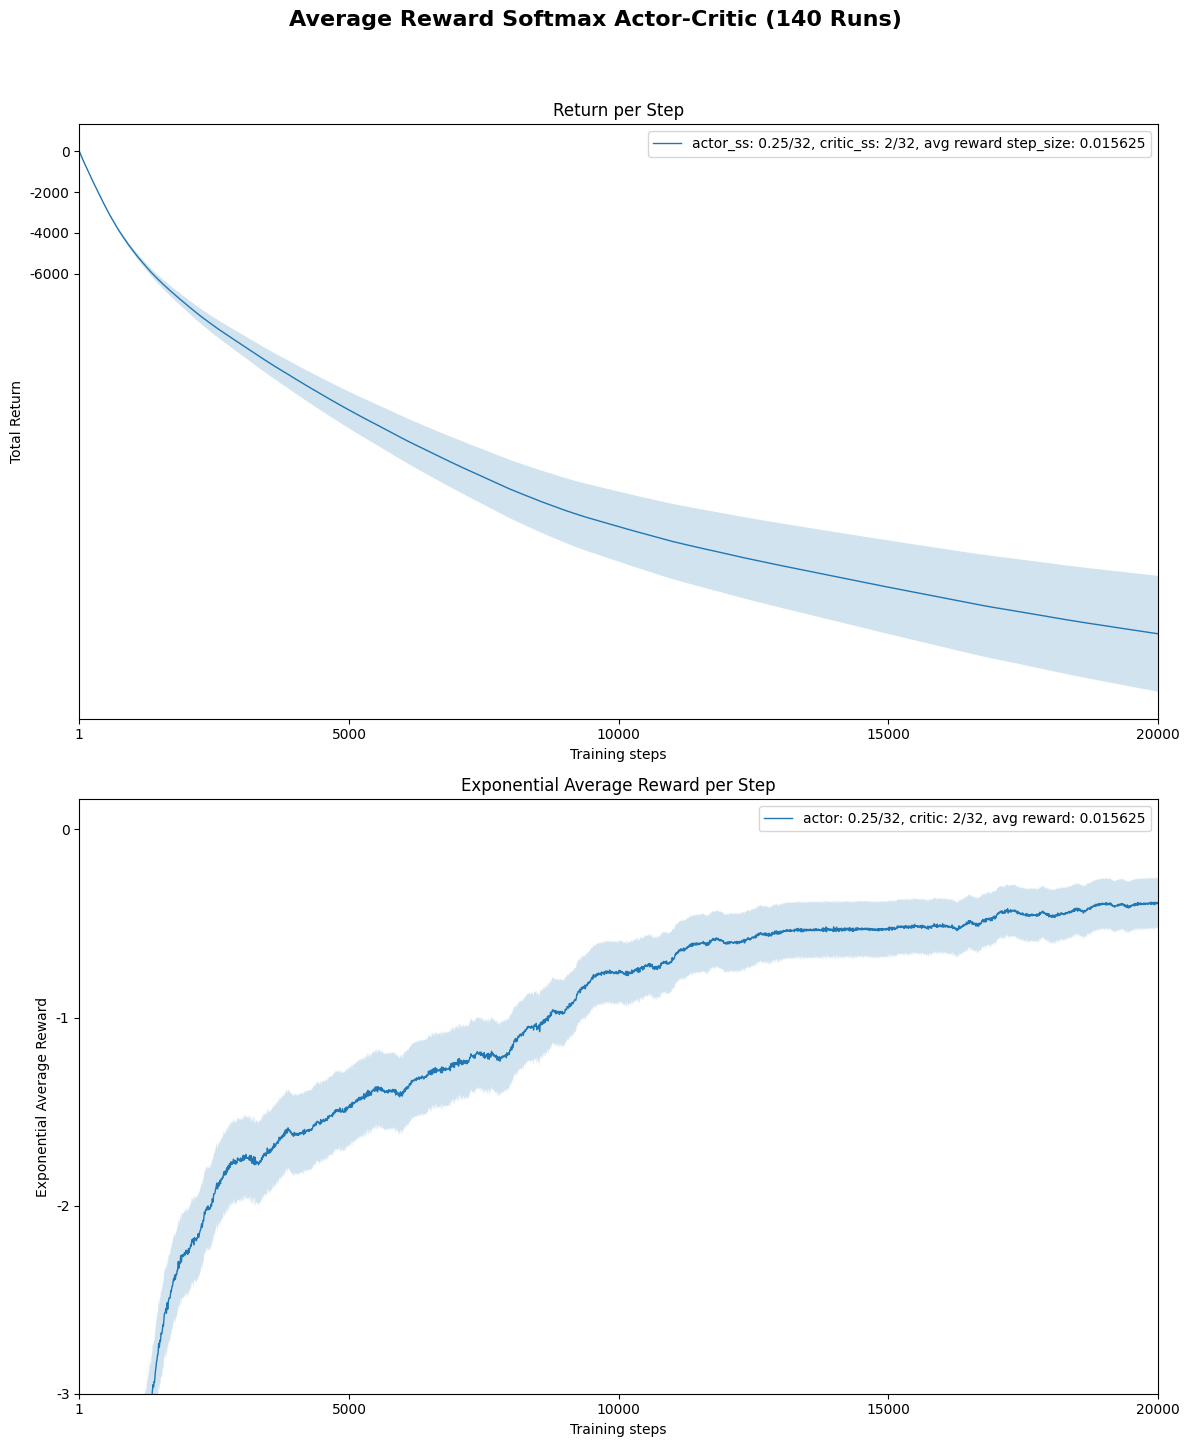

In [14]:
# Plot the "Returns per Step" and the "Exponential Average Reward per Step"
plt1_agent_sweeps = []
plt2_agent_sweeps = []

x_range = MAX_STEPS
plt_xticks = [0, 4999, 9999, 14999, 19999]
plt_xlabels = [1, 5000, 10000, 15000, 20000]
plt1_yticks = range(0, -6001, -2000)
plt2_yticks = range(-3, 1, 1)


# single plots: Exp Avg reward
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,14))

### plot1
data = return_per_step

data_mean = np.mean(data, axis=0)
data_std_err = np.std(data, axis=0)/np.sqrt(len(data))

data_mean = data_mean[:x_range]
data_std_err = data_std_err[:x_range]

plt_x_legend = range(0,len(data_mean))[:x_range]

ax[0].fill_between(plt_x_legend, data_mean - data_std_err, data_mean + data_std_err, alpha = 0.2)
graph_current_data, = ax[0].plot(plt_x_legend, data_mean, linewidth=1.0, label="actor_ss: {}/32, critic_ss: {}/32, avg reward step_size: {}".format(agent_info["actor_step_size"], agent_info["critic_step_size"], agent_info["avg_reward_step_size"]))
plt1_agent_sweeps.append(graph_current_data)

### plot2
data = exp_avg_reward_per_step

data_mean = np.mean(data, axis=0)
data_std_err = np.std(data, axis=0)/np.sqrt(len(data))

data_mean = data_mean[:x_range]
data_std_err = data_std_err[:x_range]

plt_x_legend = range(1,len(data_mean) + 1)[:x_range]

ax[1].fill_between(plt_x_legend, data_mean - data_std_err, data_mean + data_std_err, alpha = 0.2)
graph_current_data, = ax[1].plot(plt_x_legend, data_mean, linewidth=1.0, label="actor: {}/32, critic: {}/32, avg reward: {}".format(agent_info["actor_step_size"], agent_info["critic_step_size"], agent_info["avg_reward_step_size"]))
plt2_agent_sweeps.append(graph_current_data)

# plot 1
ax[0].legend(handles=[*plt1_agent_sweeps])
ax[0].set_xticks(plt_xticks)
ax[0].set_yticks(plt1_yticks)
ax[0].set_xticklabels(plt_xlabels)
ax[0].set_yticklabels(plt1_yticks)

ax[0].set_title("Return per Step")
ax[0].set_xlabel('Training steps')
ax[0].set_ylabel('Total Return', rotation=90)
ax[0].set_xlim([0,20000])


# plot 2
ax[1].legend(handles=[*plt2_agent_sweeps])
ax[1].set_xticks(plt_xticks)
ax[1].set_yticks(plt2_yticks)

ax[1].set_title("Exponential Average Reward per Step")
ax[1].set_xlabel('Training steps')
ax[1].set_ylabel('Exponential Average Reward', rotation=90)
ax[1].set_xticklabels(plt_xlabels)
ax[1].set_yticklabels(plt2_yticks)
ax[1].set_xlim([0,20000])
ax[1].set_ylim([-3, 0.16])

plt.suptitle("Average Reward Softmax Actor-Critic ({} Runs)".format(len(data)),fontsize=16, fontweight='bold', y=1.03)

plt.tight_layout()
plt.show()

In [15]:
# Test and Render the Result

# Load the class instance
with open("agent.pkl", "rb") as file:
    agent = pickle.load(file)

render = True
agent.agent_init(agent_info)
env_state, _ = test_env.reset(seed=env_info["seed"])
cos_theta, sin_theta, theta_dot = env_state
theta = np.arctan2(sin_theta, cos_theta)
last_state = [theta, theta_dot]

last_action = agent.agent_start(last_state)

num_steps = 0

while num_steps < 2500:
    num_steps += 1

    # Step env/agent
    env_state, reward, done, _, _ = test_env.step(last_action)
    cos_theta, sin_theta, theta_dot = env_state
    theta = np.arctan2(sin_theta, cos_theta)
    last_state = [theta, theta_dot]

    if render and (test_env.render() is not None):
        frames.append(test_env.render())

    if done:
        num_episodes += 1
        agent.agent_end(reward)
        roat = (reward, last_state, None, done)
    else:
        num_steps += 1
        last_action = agent.agent_step(reward, last_state)
        roat = (reward, last_state, last_action, done)

if render and frames:
    print(frames[0].shape)
    imageio.mimsave(f'./AC_final.gif', frames, fps=40)

(500, 500, 3)


## **Add your comments about the performance**

The performance of the softmax Actor-Critic agent demonstrates effective learning in the pendulum environment. The Return per Step graph shows a consistent decline in total return due to the environment's inherent penalties for energy use and deviation from the upright position. However, the narrowing confidence interval indicates that the agent's behavior is stabilizing over time. The Exponential Average Reward graph reveals a steady improvement in reward, with the agent converging around 15,000 steps, highlighting the effectiveness of the actor and critic updates. Overall, the agent exhibits reduced variability across runs and achieves convergence in its policy, suggesting that the implementation of the Actor-Critic algorithm is functioning correctly.

To further enhance performance, it is recommended to increase the resolution of state representation by using more tiles and tilings, fine-tune the learning rates for actor, critic, and average reward updates, and consider discretizing the action space into more bins to allow for finer-grained exploration. These adjustments could accelerate learning and potentially improve the agent's ability to stabilize the pendulum.

## **Bonus**
Try to "implement" and "test" the Actor-Critic but this time with **Gaussian Policy** instead of **Softmax Policy**

## Modify the Agent Class

In [30]:
class DiscretizedPendulumEnv:
    def __init__(self, env, num_bins=9):
        self.env = env
        self.num_bins = num_bins
        self.action_space = np.linspace(env.action_space.low[0], env.action_space.high[0], num_bins)
        self.observation_space = env.observation_space

    def reset(self, seed=0):
        return self.env.reset(seed=seed)

    def step(self, action_idx):
        action = [self.action_space[action_idx]]
        obs, reward, done, info, _ = self.env.step(action)
        return obs, reward, done, info, _

# Gaussian Actor-Critic Agent
class GaussianActorCriticAgent:
    def __init__(self):
        self.rand_generator = None

        self.actor_step_size = None
        self.critic_step_size = None
        self.avg_reward_step_size = None

        self.tc = None

        self.avg_reward = None
        self.critic_w = None
        self.actor_mean_w = None
        self.actor_std_w = None

        self.prev_tiles = None
        self.last_action = None
        self.action_space = None  # Initialize action space

    def agent_init(self, agent_info={}):
        self.rand_generator = np.random.RandomState(agent_info.get("seed"))

        iht_size = agent_info.get("iht_size")
        num_tilings = agent_info.get("num_tilings")
        num_tiles = agent_info.get("num_tiles")

        self.tc = PendulumTileCoder(iht_size=iht_size, num_tilings=num_tilings, num_tiles=num_tiles)

        self.actor_step_size = agent_info.get("actor_step_size") / num_tilings
        self.critic_step_size = agent_info.get("critic_step_size") / num_tilings
        self.avg_reward_step_size = agent_info.get("avg_reward_step_size")

        self.avg_reward = 0.0
        self.critic_w = np.zeros(iht_size)
        self.actor_mean_w = np.zeros(iht_size)
        self.actor_std_w = np.zeros(iht_size)

        self.prev_tiles = None
        self.last_action = None

        # Add action space to the agent
        self.action_space = agent_info.get("action_space")

    def compute_policy(self, active_tiles):
        mean = np.sum(self.actor_mean_w[active_tiles])
        std = np.exp(np.sum(self.actor_std_w[active_tiles]))  # Ensure positive std
        return mean, std

    def agent_policy(self, active_tiles):
        mean, std = self.compute_policy(active_tiles)
        action = self.rand_generator.normal(mean, std)
        return action, mean, std

    def map_action_to_index(self, action):
        return np.argmin(np.abs(self.action_space - action))

    def agent_start(self, state):
        angle, ang_vel = state
        active_tiles = self.tc.get_tiles(angle, ang_vel)

        action, mean, std = self.agent_policy(active_tiles)
        action_idx = self.map_action_to_index(action)

        self.prev_tiles = np.copy(active_tiles)
        self.last_action = action
        return action_idx

    def agent_step(self, reward, state):
        angle, ang_vel = state
        active_tiles = self.tc.get_tiles(angle, ang_vel)

        delta = (
            reward
            - self.avg_reward
            + np.sum(self.critic_w[active_tiles])
            - np.sum(self.critic_w[self.prev_tiles])
        )

        self.avg_reward += self.avg_reward_step_size * delta
        self.critic_w[self.prev_tiles] += self.critic_step_size * delta

        action, mean, std = self.agent_policy(self.prev_tiles)
        advantage = (self.last_action - mean) / (std**2)
        self.actor_mean_w[self.prev_tiles] += self.actor_step_size * delta * advantage
        self.actor_std_w[self.prev_tiles] += self.actor_step_size * delta * (
            (self.last_action - mean)**2 / (std**2) - 1
        )

        action, _, _ = self.agent_policy(active_tiles)
        action_idx = self.map_action_to_index(action)
        self.last_action = action
        self.prev_tiles = active_tiles

        return action_idx

In [31]:
env_info = {"seed": 99}
agent_info = {
    "iht_size": 4096,
    "num_tilings": 8,
    "num_tiles": 8,
    "actor_step_size": 0.1,
    "critic_step_size": 1.0,
    "avg_reward_step_size": 0.01,
    "seed": 99,
}

test_env = DiscretizedPendulumEnv(gym.make("Pendulum-v1", render_mode="rgb_array"), num_bins=11)
agent_info["action_space"] = test_env.action_space

test_agent = GaussianActorCriticAgent()
test_agent.agent_init(agent_info)

state, _ = test_env.reset(seed=env_info["seed"])
cos_beta, sin_beta, beta_dot = state
beta = np.arctan2(sin_beta, cos_beta)
last_state = [beta, beta_dot]

last_action = test_agent.agent_start(last_state)

for _ in range(10):
    next_state, reward, done, _, _ = test_env.step(last_action)
    cos_beta, sin_beta, beta_dot = next_state
    beta = np.arctan2(sin_beta, cos_beta)
    next_state = [beta, beta_dot]

    last_action = test_agent.agent_step(reward, next_state)
    print(f"Action: {last_action}, Reward: {reward}")

Action: 6, Reward: -0.0031305601830252487
Action: 5, Reward: -0.0047748686598176725
Action: 7, Reward: -0.009816981071492573
Action: 5, Reward: -0.014821670713779215
Action: 5, Reward: -0.031639163991156204
Action: 5, Reward: -0.04502480454924406
Action: 6, Reward: -0.06491443216157375
Action: 7, Reward: -0.09444900141067081
Action: 4, Reward: -0.15074356621469723
Action: 3, Reward: -0.2509091840989403


/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
